In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from inspect import signature
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import numpy as np
import datetime
%matplotlib inline

# feature ideas
1. train a model to predict transaction amount and then use the residuals as anamoly detection to say that this transaction isn't normal
2. instead of just using averages to encode categorical variables we can use "magnitude" of the vector. meaning we take the squared distance between the two. This will give more weight to higher distances

3. fill the null in merchantZip_nr_fraud_trans with averages for the country
4. need to grid search to get hyperparameters



In [2]:
trans = pd.read_csv('/Users/wcasey/Downloads/data-new/transactions_obf.csv')
labels = pd.read_csv('/Users/wcasey/Downloads/data-new/labels_obf.csv')

In [3]:
labels['label'] = 1

In [4]:
labels.head()

,reportedTime,eventId,label
0,2017-01-04T00:00:00Z,101536329A1,1
1,2017-01-04T00:00:00Z,101536425A1,1
2,2017-01-04T00:00:00Z,101536473A1,1
3,2017-01-04T00:00:00Z,101536617A1,1
4,2017-01-04T00:00:00Z,101536761A1,1


In [5]:
df = trans.merge(labels, how='left', on='eventId')

In [6]:
df['label'] = df.label.fillna(0)
df['label'] = df['label'].astype('int')

In [7]:
df['reported_delta_days'] = (pd.to_datetime(df['reportedTime']) - pd.to_datetime(df['transactionTime'])).dt.days

In [8]:
df['reportedTime'] = pd.to_datetime(df['reportedTime']).dt.date

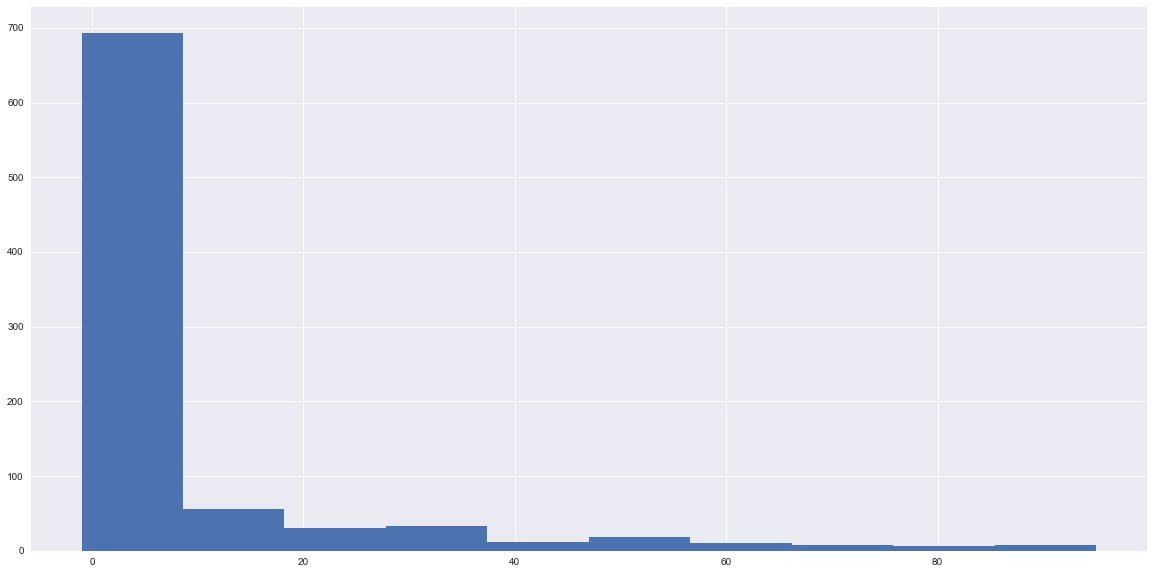

In [9]:
plt.figure(figsize=(20, 10))
# df.groupby('reported_delta_days').reported_delta_days.count().plot(kind='line')
df['reported_delta_days'].hist()

In [10]:
df['transactionTime'] = pd.to_datetime(df['transactionTime'])

In [11]:
df['transactionDate'] = df['transactionTime'].dt.date

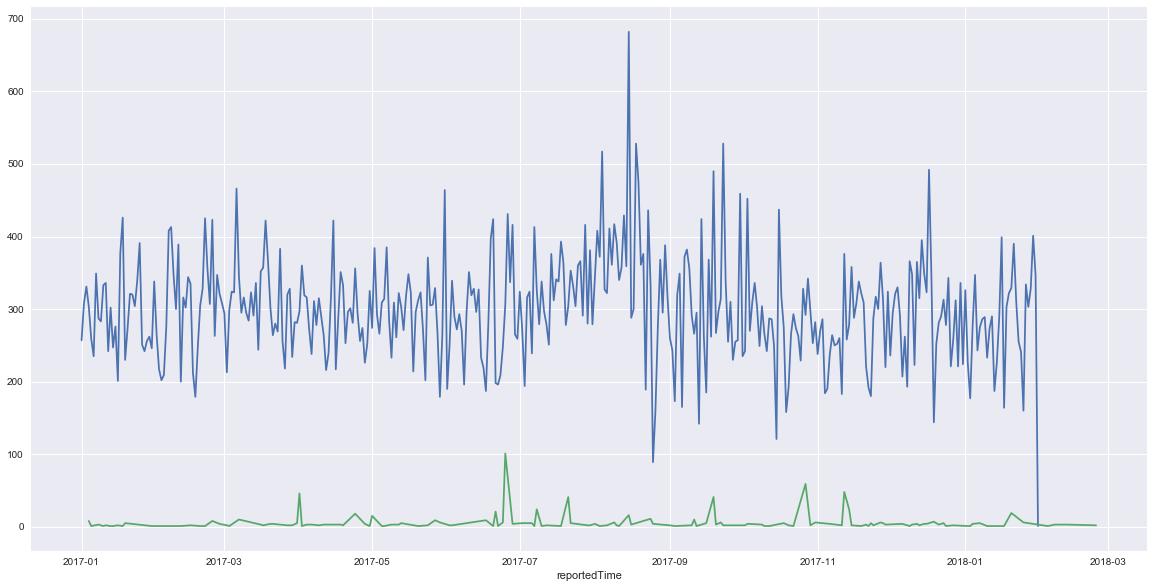

In [12]:
plt.figure(figsize=(20, 10))
df.groupby('transactionDate').transactionDate.count().plot(kind='line')
df.groupby('reportedTime').reportedTime.count().plot(kind='line')

In [13]:
df.groupby('label').label.count()

label
0    117746
1       875
Name: label, dtype: int64

In [14]:
def non_usable_lable(report_time, label, split_date):
    split_date = datetime.datetime.strptime(split_date, '%Y-%m-%d').date()
    if report_time > split_date:
        return 0
    else:
        return label


def timeseries_train_test(df, label, split_date):
    
    X_train = df[df['transactionTime'] < split_date]
    X_train['usable_label'] = X_train[['reportedTime', label]].apply(lambda x: non_usable_lable(x['reportedTime'], x[label], split_date), axis=1)
    y_train = X_train['usable_label']
    
    X_test = df[df['transactionTime'] >= split_date]
    y_test = X_test[label]
    return X_train, X_test, y_train, y_test
    

In [15]:
split_date = '2017-09-01'
X_train, X_test, y_train, y_test = timeseries_train_test(df, 'label', split_date)

/Users/wcasey/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [16]:
X_train[['label', 'usable_label']].sum()

label           539
usable_label    518
dtype: int64

In [17]:
X_test[['label']].sum()

label    336
dtype: int64

In [18]:
X_train

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,reportedTime,label,reported_delta_days,transactionDate,usable_label
0,2017-01-01 00:00:00,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500,NaT,0,NaN,2017-01-01,0
1,2017-01-01 00:49:03,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500,NaT,0,NaN,2017-01-01,0
2,2017-01-01 00:43:17,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500,NaT,0,NaN,2017-01-01,0
3,2017-01-01 00:15:07,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500,NaT,0,NaN,2017-01-01,0
4,2017-01-01 00:37:09,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500,NaT,0,NaN,2017-01-01,0
5,2017-01-01 01:33:23,87747828A1,0cc51b98,6b32dc,5968,442,NaN,1,5.94,8500,NaT,0,NaN,2017-01-01,0
6,2017-01-01 01:39:19,26312005A1,d5a8f4bc,bb3ef2,5968,826,KT11,1,312.72,10500,NaT,0,NaN,2017-01-01,0
7,2017-01-01 01:36:52,68541785A1,4acaa3e9,f51d17,5968,826,NR1,1,11.00,8500,NaT,0,NaN,2017-01-01,0
8,2017-01-01 02:24:10,73437030A1,d3a5049c,f24576,5999,442,NaN,1,5.93,500,NaT,0,NaN,2017-01-01,0
9,2017-01-01 02:41:12,33976065A1,b9b98bc8,7d5803,5499,826,NR1,81,21.00,8500,NaT,0,NaN,2017-01-01,0


In [18]:
# X_train, X_test, y_train, y_test = train_test_split(df, df.label, test_size=.33, random_state=100, )

In [19]:
print(X_train.transactionTime.min(), X_train.transactionTime.max())
print(X_test.transactionTime.min(), X_test.transactionTime.max())

2017-01-01 00:00:00 2017-08-31 23:46:43
2017-09-01 00:35:20 2018-01-31 00:04:44


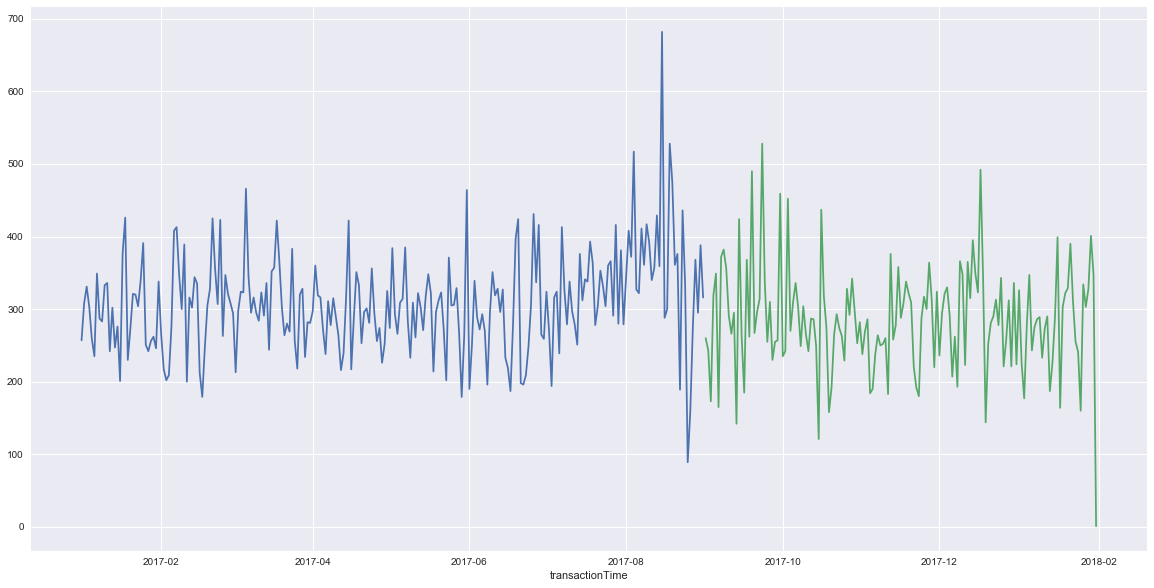

In [20]:
plt.figure(figsize=(20, 10))
xtrain_date = pd.to_datetime(X_train['transactionTime']).dt.date.to_frame()
xtest_date = pd.to_datetime(X_test['transactionTime']).dt.date.to_frame()
# pd.to_datetime(X_train['transactionTime'])
xtrain_date.groupby('transactionTime').transactionTime.count().plot(kind='line')
xtest_date.groupby('transactionTime').transactionTime.count().plot(kind='line')


In [21]:
X_test.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,reportedTime,label,reported_delta_days,transactionDate
75037,2017-09-01 00:35:20,21050686A1,222f5c2a,96878e,5942,442,NaN,81,4.72,9500,NaT,0,NaN,2017-09-01
75038,2017-09-01 00:36:31,21059662A1,222f5c2a,96878e,5942,442,NaN,81,35.91,9500,NaT,0,NaN,2017-09-01
75039,2017-09-01 01:11:20,39556445A1,085c30a6,571029,6300,826,NR1,1,148.77,7500,NaT,0,NaN,2017-09-01
75040,2017-09-01 01:25:53,7594810A1,8f51e763,a61088,4816,442,NaN,81,9.91,500,NaT,0,NaN,2017-09-01
75041,2017-09-01 01:43:32,7595338A1,8f51e763,a61088,4816,442,NaN,81,6.71,500,NaT,0,NaN,2017-09-01


In [22]:
X_train.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,reportedTime,label,reported_delta_days,transactionDate,usable_label
0,2017-01-01 00:00:00,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500,NaT,0,NaN,2017-01-01,0
1,2017-01-01 00:49:03,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500,NaT,0,NaN,2017-01-01,0
2,2017-01-01 00:43:17,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500,NaT,0,NaN,2017-01-01,0
3,2017-01-01 00:15:07,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500,NaT,0,NaN,2017-01-01,0
4,2017-01-01 00:37:09,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500,NaT,0,NaN,2017-01-01,0


In [23]:
# Reassign the label column with only the usable labels
X_train['label'] = X_train['usable_label']
y_train = X_train.label

X_train = X_train.drop(columns='usable_label')

/Users/wcasey/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [117]:
X_train = X_train.drop(columns='reported_delta_days')
X_test = X_test.drop(columns='reported_delta_days')

In [118]:
df.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,reportedTime,label,reported_delta_days,transactionDate
0,2017-01-01 00:00:00,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500,NaT,0,NaN,2017-01-01
1,2017-01-01 00:49:03,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500,NaT,0,NaN,2017-01-01
2,2017-01-01 00:43:17,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500,NaT,0,NaN,2017-01-01
3,2017-01-01 00:15:07,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500,NaT,0,NaN,2017-01-01
4,2017-01-01 00:37:09,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500,NaT,0,NaN,2017-01-01


In [119]:
X_test_old = X_test.copy()

In [120]:
def get_fraud_percent(df, col):
    a = df[[col, 'label']].groupby(col).agg({'label': [np.size, np.sum]})
    a.columns = [col + '_' +'nr_trans', col + '_' + 'nr_fraud_trans']
    a = a.reset_index()
    a[col + '_' + 'fraud_rate'] = a[col + '_' + 'nr_fraud_trans']/a[col + '_' +'nr_trans']
#     return a[[col, col + '_' + 'nr_fraud_trans', col + '_' +'nr_trans']]
    return a[[col, col + '_' + 'fraud_rate', col + '_' +'nr_trans']]


def leftover_nulls_in_test(X_train, X_test):
    for col in X_test:
        if X_test[col].dtype == int or X_test[col].dtype == float: 
            X_test[col] = X_test[col].fillna(X_train[col].mean())
    return X_test
    


def preprocessing_cat_cols(X_train, X_test):
    dataframe_list = []
    for dataframe in [X_train, X_test]:
        dataframe = dataframe.drop(columns=['reportedTime', 'eventId'])

        for col in ['accountNumber', 'merchantId', 'mcc','merchantCountry', 'merchantZip', 'posEntryMode']:
            dataframe = dataframe.merge(get_fraud_percent(X_train[[col, 'label']], col=col), on=col, how='left')
#             dataframe = dataframe.drop(columns=col)

        #fill null values see number 3 in notes
        if len(dataframe_list) == 0:
            dataframe['merchantZip_fraud_rate'] = dataframe['merchantZip_fraud_rate'].fillna(dataframe.merchantZip_fraud_rate.mean())
            dataframe['merchantZip_nr_trans'] = dataframe['merchantZip_nr_trans'].fillna(dataframe['merchantZip_nr_trans'].mean())
        else:
            dataframe['merchantZip_fraud_rate'] = dataframe['merchantZip_fraud_rate'].fillna(dataframe_list[0].merchantZip_fraud_rate.mean())
            dataframe['merchantZip_nr_trans'] = dataframe['merchantZip_nr_trans'].fillna(dataframe_list[0]['merchantZip_nr_trans'].mean())
            
        dataframe_list.append(dataframe)
    return dataframe_list

In [121]:
X_train, X_test = preprocessing_cat_cols(X_train, X_test)
# X_test = leftover_nulls_in_test(X_train, X_test)

In [122]:
test = get_fraud_percent(df, 'merchantId')

In [123]:
test.sort_values('merchantId_fraud_rate', ascending=False)

,merchantId,merchantId_fraud_rate,merchantId_nr_trans
19860,99460,1.0,1
7877,3dfbdf,1.0,1
28387,d98652,1.0,1
30298,e8b89a,1.0,1
30287,e8a5b8,1.0,1
13748,6ab85e,1.0,1
7183,38ec44,1.0,2
9195,48260b,1.0,2
5495,2c3fc4,1.0,1
24246,ba18d0,1.0,1


In [124]:
full_data = get_fraud_percent(df, 'merchantId')

full_data.columns = ['merchantId', 'full_data_rate', 'full_data_nr']

test2 = X_test.groupby('merchantId').agg({'merchantId_fraud_rate': np.mean}).reset_index().sort_values('merchantId_fraud_rate', ascending=False)

testjoined = full_data.merge(test2, on='merchantId', how='left')


# this is the percent of merchants that haven't been seen yet in the test set
print(len(testjoined[testjoined.merchantId_fraud_rate.isnull()])/len(testjoined))

0.8004320820955981


In [127]:
test2

,merchantId,merchantId_fraud_rate
14905,f273ef,1.000000
237,04dc71,1.000000
4043,42f8f8,1.000000
8057,8392eb,1.000000
6280,675d01,1.000000
8971,918ebe,1.000000
10275,a62591,1.000000
9336,97bdb0,1.000000
5656,5c9c0f,1.000000
6135,64d73e,1.000000


In [125]:
df[df['merchantId'] == '000a24']

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,reportedTime,label,reported_delta_days,transactionDate
115781,2018-01-21 14:57:51,39559997A1,085c30a6,000a24,5999,826,CV10,81,30.0,8500,NaT,0,NaN,2018-01-21


In [126]:
testjoined[testjoined['merchantId'] == '000a24']

,merchantId,full_data_rate,full_data_nr,merchantId_fraud_rate
3,000a24,0.0,1,NaN


<Figure size 1080x576 with 0 Axes>

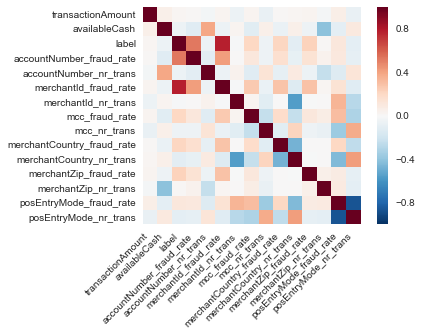

<Figure size 1080x576 with 0 Axes>

In [299]:
corr = X_train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.figure(figsize=(15, 8))

In [300]:
X_train.head()

,transactionTime,transactionAmount,availableCash,label,transactionDate,accountNumber_fraud_rate,accountNumber_nr_trans,merchantId_fraud_rate,merchantId_nr_trans,mcc_fraud_rate,mcc_nr_trans,merchantCountry_fraud_rate,merchantCountry_nr_trans,merchantZip_fraud_rate,merchantZip_nr_trans,posEntryMode_fraud_rate,posEntryMode_nr_trans
0,2017-01-01 00:00:00,10.72,7500,0,2017-01-01,0.0,215,0.000000,6,0.005810,1377,0.003164,60998,0.000000,225.000000,0.020009,6697
1,2017-01-01 00:49:03,21.19,4500,0,2017-01-01,0.0,242,0.000000,5,0.004348,1380,0.003164,60998,0.000000,11.000000,0.016575,21901
2,2017-01-01 00:43:17,5.04,9500,0,2017-01-01,0.0,43,0.001399,715,0.029098,2440,0.007740,9302,0.003164,1540.194138,0.016575,21901
3,2017-01-01 00:15:07,21.00,7500,0,2017-01-01,0.0,144,0.000000,14,0.004348,1380,0.003164,60998,0.000000,132.000000,0.016575,21901
4,2017-01-01 00:37:09,47.00,10500,0,2017-01-01,0.0,63,0.000000,143,0.000197,15261,0.003164,60998,0.000000,185.000000,0.016575,21901


In [301]:
X_test.head()

,transactionTime,transactionAmount,availableCash,label,transactionDate,accountNumber_fraud_rate,accountNumber_nr_trans,merchantId_fraud_rate,merchantId_nr_trans,mcc_fraud_rate,mcc_nr_trans,merchantCountry_fraud_rate,merchantCountry_nr_trans,merchantZip_fraud_rate,merchantZip_nr_trans,posEntryMode_fraud_rate,posEntryMode_nr_trans
0,2017-09-01 00:35:20,4.72,9500,0,2017-09-01,0.0,148.0,0.0,2104.0,0.000382,2619.0,0.007740,9302.0,0.003164,1540.194138,0.016575,21901
1,2017-09-01 00:36:31,35.91,9500,0,2017-09-01,0.0,148.0,0.0,2104.0,0.000382,2619.0,0.007740,9302.0,0.003164,1540.194138,0.016575,21901
2,2017-09-01 01:11:20,148.77,7500,0,2017-09-01,0.0,153.0,0.0,5.0,0.005181,579.0,0.003164,60998.0,0.000000,132.000000,0.020009,6697
3,2017-09-01 01:25:53,9.91,500,0,2017-09-01,0.0,50.0,0.0,116.0,0.019851,403.0,0.007740,9302.0,0.003164,1540.194138,0.016575,21901
4,2017-09-01 01:43:32,6.71,500,0,2017-09-01,0.0,50.0,0.0,116.0,0.019851,403.0,0.007740,9302.0,0.003164,1540.194138,0.016575,21901


In [302]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

75037 75037
43584 43584


In [303]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth=5, max_features=.5, random_state=300)

In [306]:
traindata = X_train.drop(columns=['label', 'transactionTime', 'transactionDate'])
# traindata = X_train.drop(columns=['label', 'transactionTime'])
RFmodel = rf.fit(traindata, y_train)

In [308]:
testdata = X_test.drop(columns=['label', 'transactionTime', 'transactionDate'])
# testdata = X_test.drop(columns=['label', 'transactionTime'])
predictions_prob_test = RFmodel.predict_proba(testdata)
predictions_prob_train = RFmodel.predict_proba(traindata)

In [309]:
# metrics.f1_score(y_test, predictions)

In [324]:
prob1__test = [a[1] for a in predictions_prob_test]
prob1__train = [a[1] for a in predictions_prob_train]

Text(0.5,1,'2-class Precision-Recall curve: AP=0.93')

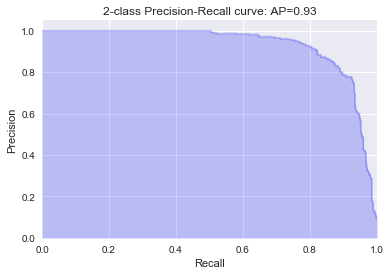

In [311]:
#Metrics in Train
precision, recall, _ = metrics.precision_recall_curve(y_train, prob1__train)
average_precision_score = metrics.average_precision_score(y_train, prob1__train)
# metrics.fbeta_score()

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision_score))

In [312]:
average_precision_score

0.92949248415467134

In [329]:
X_test.head()

,transactionTime,transactionAmount,availableCash,label,transactionDate,accountNumber_fraud_rate,accountNumber_nr_trans,merchantId_fraud_rate,merchantId_nr_trans,mcc_fraud_rate,mcc_nr_trans,merchantCountry_fraud_rate,merchantCountry_nr_trans,merchantZip_fraud_rate,merchantZip_nr_trans,posEntryMode_fraud_rate,posEntryMode_nr_trans
0,2017-09-01 00:35:20,4.72,9500,0,2017-09-01,0.0,148.0,0.0,2104.0,0.000382,2619.0,0.007740,9302.0,0.003164,1540.194138,0.016575,21901
1,2017-09-01 00:36:31,35.91,9500,0,2017-09-01,0.0,148.0,0.0,2104.0,0.000382,2619.0,0.007740,9302.0,0.003164,1540.194138,0.016575,21901
2,2017-09-01 01:11:20,148.77,7500,0,2017-09-01,0.0,153.0,0.0,5.0,0.005181,579.0,0.003164,60998.0,0.000000,132.000000,0.020009,6697
3,2017-09-01 01:25:53,9.91,500,0,2017-09-01,0.0,50.0,0.0,116.0,0.019851,403.0,0.007740,9302.0,0.003164,1540.194138,0.016575,21901
4,2017-09-01 01:43:32,6.71,500,0,2017-09-01,0.0,50.0,0.0,116.0,0.019851,403.0,0.007740,9302.0,0.003164,1540.194138,0.016575,21901


Text(0.5,1,'2-class Precision-Recall curve: AP=0.02')

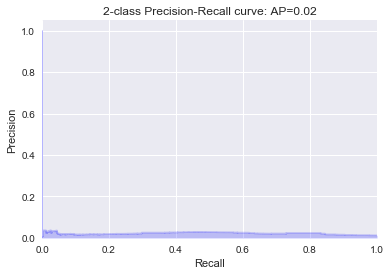

In [313]:
precision, recall, _ = metrics.precision_recall_curve(y_test, prob1__test)
average_precision_score = metrics.average_precision_score(y_test, prob1__test)
# metrics.fbeta_score()

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision_score))

In [257]:
X_train.columns

Index(['transactionTime', 'transactionAmount', 'availableCash', 'label',
       'accountNumber_fraud_rate', 'accountNumber_nr_trans',
       'merchantId_fraud_rate', 'merchantId_nr_trans', 'mcc_fraud_rate',
       'mcc_nr_trans', 'merchantCountry_fraud_rate',
       'merchantCountry_nr_trans', 'merchantZip_fraud_rate',
       'merchantZip_nr_trans', 'posEntryMode_fraud_rate',
       'posEntryMode_nr_trans'],
      dtype='object')

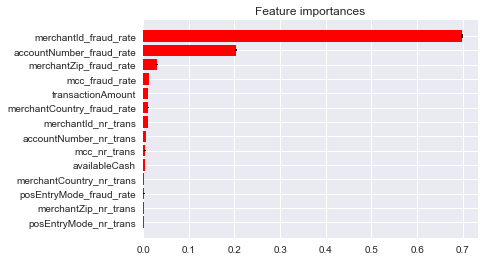

In [258]:
X = X_train.drop(columns=['label', 'transactionTime'])
importances = RFmodel.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFmodel.estimators_],axis=0)
feature = np.array(X.columns)

importance_df = pd.DataFrame({'feature': feature, 'importances': importances, 'std': std})
importance_df = importance_df.sort_values(by='importances', ascending=True)

plt.figure()
plt.title("Feature importances")
plt.barh(importance_df['feature'], importance_df['importances'],
       color="r", yerr=importance_df['std'], align="center")



plt.show()


/Users/wcasey/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


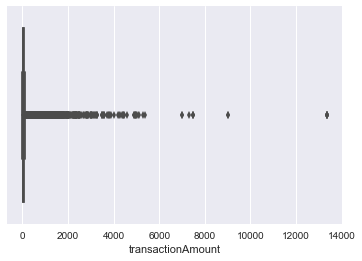

In [280]:
sns.boxplot(df['transactionAmount'])

In [189]:
df.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,reportedTime,label
0,2017-01-01T00:00:00Z,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500,NaN,0
1,2017-01-01T00:49:03Z,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500,NaN,0
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500,NaN,0
3,2017-01-01T00:15:07Z,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500,NaN,0
4,2017-01-01T00:37:09Z,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500,NaN,0


In [190]:
merchantid = df.groupby(['merchantId', 'label']).agg({'transactionAmount': [np.mean, np.size, np.std]})
merchantid.columns = merchantid.columns.droplevel(0)
new_cols = {w:"merchantId_" + w for w in merchantid.columns}
merchantid = merchantid.rename(columns=new_cols).reset_index()

In [277]:
merchantid.head()

,merchantId,label,merchantId_mean,merchantId_size,merchantId_std
0,0.00E+00,0,35.960,1.0,NaN
1,00018e,0,23.765,2.0,1.534422
2,0007fe,0,27.950,1.0,NaN
3,000a24,0,30.000,1.0,NaN
4,000b8a,0,12.000,1.0,NaN


In [261]:
merchantid_2 = merchantid.pivot(index='merchantId', columns='label', values=['merchantId_mean', 'merchantId_size','merchantId_std' ])

# merchantid.pivot(index=merchantid['merchantid'], columns=merchantid['label'], values=merchantid['merchantid_mean'])

In [267]:

merchantid_2.columns = [w[0] + "_" + str(w[1]) for w in merchantid_2.columns]

In [270]:
merchantid_2 = merchantid_2.fillna(0)

In [275]:
merchantid_2.sort_values('merchantId_size_1', ascending=False)

,merchantId_mean_0,merchantId_mean_1,merchantId_size_0,merchantId_size_1,merchantId_std_0,merchantId_std_1
merchantId,,,,,,
4fd0ff,5.064904,7.053061,1505.0,49.0,6.969063,2.133700
2be1cd,7.582611,34.332500,452.0,48.0,14.386564,23.306849
707b6c,9.033333,6.061579,3.0,19.0,0.032146,1.751876
6a5933,0.000000,2.844118,0.0,17.0,0.000000,1.332277
e57467,0.000000,107.911429,0.0,14.0,0.000000,42.994515
5ffdb0,0.000000,11.214615,0.0,13.0,0.000000,16.447265
5b2d60,9.493333,4.369167,6.0,12.0,6.451157,0.026097
5025b0,0.620240,0.627500,541.0,12.0,0.183788,0.050834
7f7cdb,34.042248,81.978889,1775.0,9.0,86.623572,130.172541


In [61]:
range(len(df))

range(0, 118621)

In [66]:
trans_time = df.sort_values('transactionTime').reset_index()['index'].tolist()

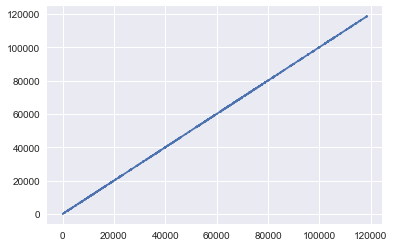

In [69]:
plt.plot(trans_time)

In [74]:
np.matrix(df.drop(columns='label'))

matrix([['2017-01-01T00:00:00Z', '18688431A1', '94f9b4e7', ..., 10.72, 7500,
         nan],
        ['2017-01-01T00:49:03Z', '2164986A1', '648e19cf', ..., 21.19, 4500,
         nan],
        ['2017-01-01T00:43:17Z', '31294145A1', 'c0ffab1b', ..., 5.04, 9500,
         nan],
        ..., 
        ['2018-01-30T23:59:03Z', '103582443A1', 'd3c036ac', ..., 17.0, 8500,
         nan],
        ['2018-01-31T00:04:44Z', '14841868A1', 'ec212849', ..., 11.0, 7500,
         nan],
        ['2018-01-30T23:49:09Z', '14844076A1', 'ec212849', ..., 11.0, 7500,
         nan]], dtype=object)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='label'), df.label, test_size=.33, random_state=100)

In [76]:
X_train.transactionTime

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,reportedTime
90832,2017-10-25T14:55:34Z,1181318A1,76676ffc,03a635,5411,826,CB7,5,4.17,8500,NaN
38297,2017-05-08T03:32:57Z,101445811A1,66b2f8b3,c5a3cd,7311,372,NaN,81,0.89,500,NaN
1509,2017-01-06T08:08:31Z,51246243A1,cff19319,cf63df,7011,826,SO42,5,52.42,4500,NaN
8631,2017-01-30T15:31:28Z,1632540A1,ba33bfd5,aa2b88,6012,826,0,1,21.00,500,NaN
63884,2017-08-01T04:39:16Z,18142071A1,460b553f,102330,5411,826,SL9,5,13.25,8500,NaN
32979,2017-04-20T08:32:03Z,77978467A1,2e6bbec5,8646c5,5411,826,KA7,5,14.44,8500,NaN
28913,2017-04-06T19:39:17Z,5324588A1,7d6fa7d8,458230,5983,826,EX33,5,62.38,7500,NaN
14760,2017-02-20T05:20:52Z,22628561A1,b65dc5a7,9ef205,9402,826,MK7,5,5.14,9500,NaN
76735,2017-09-07T05:33:02Z,28325220A1,83d67171,de83d0,6011,826,B79,5,49.00,500,NaN
61453,2017-07-25T00:09:33Z,93421548A1,afc68591,9d2d0c,5813,826,0,5,25.00,2500,NaN


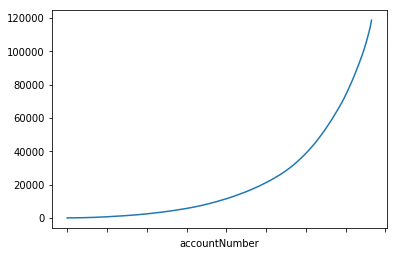

In [24]:
df.groupby('accountNumber').accountNumber.count().sort_values().cumsum().plot(kind='line')

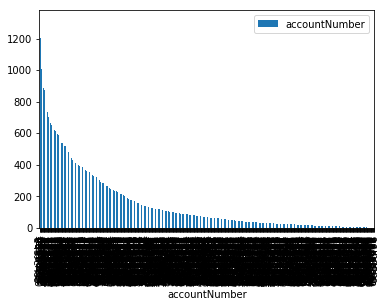

In [17]:
df.groupby('accountNumber').accountNumber.count().sort_values(ascending=False).to_frame().plot(kind='bar')

In [19]:
len(df.groupby('accountNumber').accountNumber.count())

766

In [20]:
len(df.groupby('merchantId').accountNumber.count())

33327

In [8]:
df.describe()

,mcc,merchantCountry,posEntryMode,transactionAmount,availableCash
count,118621.000000,118621.000000,118621.000000,118621.000000,118621.000000
mean,5834.407272,759.124388,28.552651,53.674774,6625.508974
std,976.183515,154.070084,35.647616,183.665315,3410.289486
min,742.000000,31.000000,0.000000,-0.150000,500.000000
25%,5411.000000,826.000000,5.000000,8.030000,4500.000000
50%,5691.000000,826.000000,5.000000,20.250000,7500.000000
75%,5967.000000,826.000000,81.000000,49.000000,8500.000000
max,9405.000000,840.000000,91.000000,13348.000000,18500.000000


In [9]:
df[df['eventId'] == '101536329A1']

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash
743,2017-01-03T13:27:02Z,101536329A1,f42ba1f1,aebafc,4814,826,0,1,9.0,1500


In [5]:
labels


,reportedTime,eventId
0,2017-01-04T00:00:00Z,101536329A1
1,2017-01-04T00:00:00Z,101536425A1
2,2017-01-04T00:00:00Z,101536473A1
3,2017-01-04T00:00:00Z,101536617A1
4,2017-01-04T00:00:00Z,101536761A1
5,2017-01-04T00:00:00Z,101536857A1
6,2017-01-04T00:00:00Z,101536905A1
7,2017-01-04T00:00:00Z,101536953A1
8,2017-01-05T00:00:00Z,104586217A1
9,2017-01-08T00:00:00Z,20197235A1
